In [36]:
import torch
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from cvxpylayers.torch import CvxpyLayer
from scipy.linalg import solve_discrete_are
from extquadcontrol import lqr_average
from PIL import Image
import matplotlib as mpl
from utils import latexify

torch.set_default_dtype(torch.double)

In [37]:
L = 2.8
h = .2
n = 6
m = 2

lam_1 = 1
lam_2 = 1
lam_3 = 10
lam_4 = 10

In [38]:
def split_state_control(x, u):
    assert x.ndim == 2
    assert u.ndim == 2
    assert x.shape[0] == u.shape[0]
    assert x.shape[1] == n
    assert u.shape[1] == m

    return x[:, 0], x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5], u[:, 0], u[:, 1]

def f_batch(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)
    
    curvatures_to_not_change = torch.rand_like(curvature) < .95 # change on average every 4 seconds
    curvature_next = curvatures_to_not_change * curvature + ~curvatures_to_not_change * .1 * torch.randn_like(curvature)
    vdes_to_not_change = torch.rand_like(vdes) < .98 # change on average every 10 seconds
    vdes_next = vdes_to_not_change * vdes + ~vdes_to_not_change * torch.distributions.Uniform(3, 6).sample(sample_shape=vdes.shape)
    xnext = torch.stack([
        s + h * v / (1 - e * curvature) * torch.cos(dpsi),
        e + h * v * torch.sin(dpsi),
        dpsi + h * v * (curvature + z / L - curvature / (1 - e * curvature) * torch.cos(dpsi)),
        v + h * a,
        vdes_next,
        curvature_next
    ], dim=1)
    
    xnext[:, 1] += 1e-1*torch.randn(x.shape[0])
    xnext[:, 2] += 1e-2*torch.randn(x.shape[0])
    xnext[:, 3] += 1e-1*torch.randn(x.shape[0])
    
    return xnext

def cost_batch(x, u):
    s, e, dpsi, v, vdes, curvature, a, z = split_state_control(x, u)

    return (v - vdes).pow(2) + lam_1 * e.pow(2) + lam_2 * dpsi.pow(2) + \
        lam_3 * a.pow(2) + lam_4 * z.pow(2)

In [39]:
def plot_path(X):
    E, N, psi = np.zeros(1), np.zeros(1), np.ones(1)*np.pi/2
    E_veh, N_veh = [np.zeros(1)]*2 
    ds = X[-1,0] / 100
    for s in np.linspace(0, X[-1,0], 100):
        e = np.interp(s, X[:, 0], X[:, 1])
        dpsi = np.interp(s, X[:, 0], X[:, 2])
        t = mpl.markers.MarkerStyle(marker=9)
        t._transform = t.get_transform().rotate_deg(np.rad2deg(-psi[-1]-dpsi + np.pi/2))
        plt.scatter((E_veh[-1],), (N_veh[-1],), s=3, c='k', marker=t, alpha=.5)
        E_veh = np.append(E_veh, E[-1] - e * np.sin(psi[-1]))
        N_veh = np.append(N_veh, N[-1] + e * np.cos(psi[-1]))
        E = np.append(E, E[-1] + ds * np.sin(psi[-1]))
        N = np.append(N, N[-1] + ds * np.cos(psi[-1]))
        psi = np.append(psi, psi[-1] + ds * np.interp(s, X[:, 0], X[:, -1]))
    plt.plot(E, N, c='k', linewidth=1)
    extent = max(np.max(E) - np.min(E) + 2, np.max(N) - np.min(N) + 2)
    E_middle = .5 * (np.max(E) + np.min(E))
    N_middle = .5 * (np.max(N) + np.min(N))
    plt.xlim(E_middle - extent/2, E_middle + extent/2)
    plt.ylim(N_middle - extent/2, N_middle + extent/2)

In [40]:
# approximate value function
P_sqrt = cp.Parameter((4, 4))
q = cp.Parameter(4)

# dynamics
fx = cp.Parameter(4)
B = cp.Parameter((4, 2))
curvature = cp.Parameter(1)

u = cp.Variable(2)
y = cp.Variable(4)

a = u[0]
z = u[1]

objective = lam_3 * cp.square(a) + lam_4 * cp.square(z) + \
    cp.sum_squares(P_sqrt @ y) + q @ y
constraints = [y == fx + B @ u, cp.abs(a) <= 2, cp.abs(z + L * curvature) <= .68]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [P_sqrt, q, fx, B, curvature], [u])

In [41]:
def loss(time_horizon, batch_size, P_sqrt, q, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    X, U = [], []
    x = torch.zeros(batch_size, n)
    x[:, 1] = .5
    x[:, 2] = .1
    x[:, 3] = 3
    x[:, 4] = 4.5
    loss = 0.0
    for _ in range(time_horizon):
        _, e, dpsi, v, vdes, curvature, _, _ = split_state_control(x, torch.zeros(batch_size, 2))
        enext = e + h * v * torch.sin(dpsi)
        dpsi_next = dpsi + h * v * (curvature - curvature / (1 - e * curvature) * torch.cos(dpsi))
        fx = torch.stack([
                enext,
                dpsi_next,
                v - .98*vdes-.02*4.5,
                enext + h * v * torch.sin(dpsi_next)
            ], dim=1)
        B = torch.zeros(batch_size, 4, 2)
        B[:, 1, 1] = h * v / L
        B[:, 2, 0] = h
        B[:, 3, 1] = h * h * v * v / L
        u, = policy(P_sqrt, q, fx, B, curvature.unsqueeze(-1), solver_args={"acceleration_lookback": 0})
        X.append(x.detach().numpy().squeeze())
        U.append(u.detach().numpy().squeeze())
        loss += cost_batch(x, u).mean() / time_horizon
        x = f_batch(x, u)
    return loss, np.array(X), np.array(U)

In [48]:
P_sqrt = torch.eye(4)
P_sqrt.requires_grad_(True)
q = torch.zeros(4, requires_grad=True)

In [43]:
losses_monte_carlo_untrained = [loss(100, 1, torch.eye(4), torch.zeros(4), seed=1000+k)[0] for k in range(100)]

it: 001, loss: 3.512


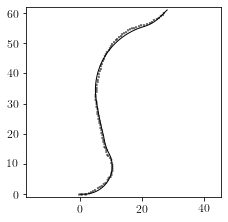

it: 002, loss: 3.706


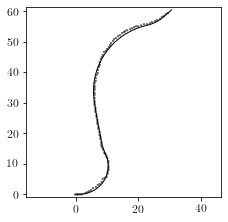

it: 003, loss: 3.693


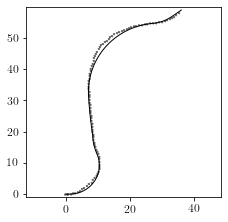

it: 004, loss: 1.907


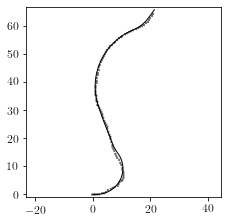

it: 005, loss: 1.765


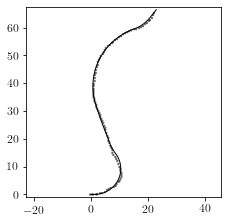

it: 006, loss: 1.637


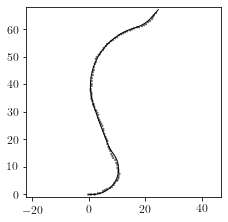

it: 007, loss: 1.563


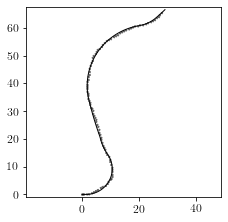

it: 008, loss: 1.393


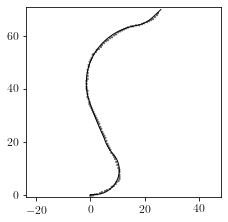

it: 009, loss: 1.386


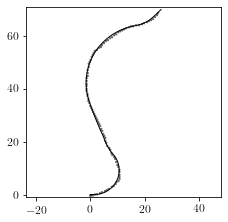

it: 010, loss: 1.333


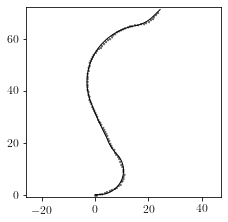

it: 011, loss: 1.325


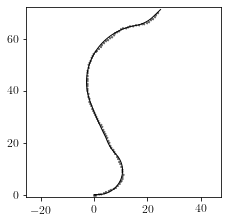

it: 012, loss: 1.331


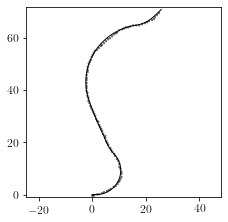

it: 013, loss: 1.321


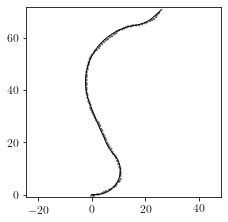

it: 014, loss: 1.316


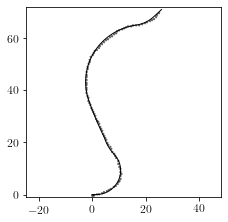

it: 015, loss: 1.291


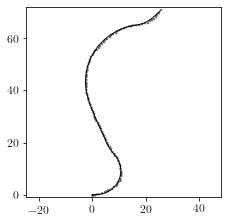

it: 016, loss: 1.282


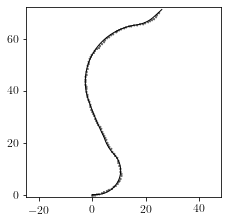

it: 017, loss: 1.272


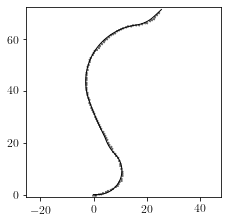

it: 018, loss: 1.269


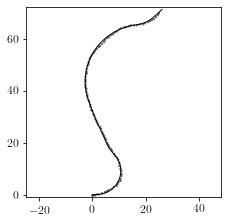

it: 019, loss: 1.247


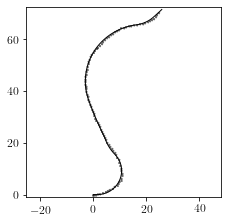

it: 020, loss: 1.228


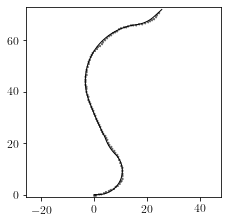

it: 021, loss: 1.210


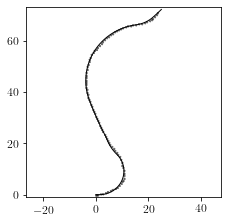

it: 022, loss: 1.195


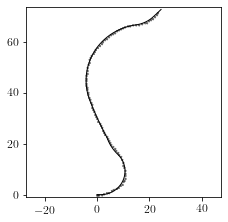

it: 023, loss: 1.199


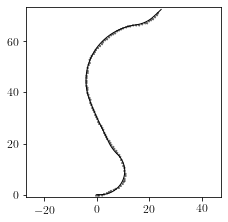

it: 024, loss: 1.207


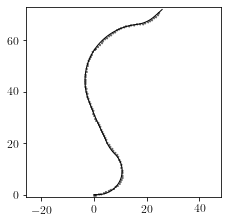

it: 025, loss: 1.203


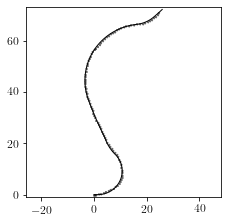

it: 026, loss: 1.194


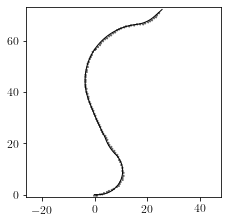

it: 027, loss: 1.187


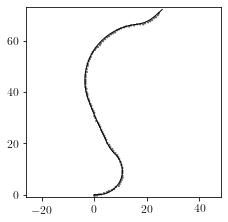

it: 028, loss: 1.180


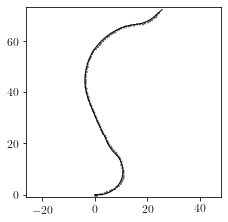

it: 029, loss: 1.166


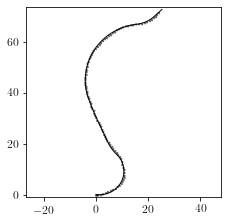

it: 030, loss: 1.152


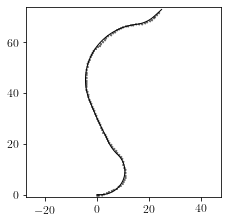

it: 031, loss: 1.144


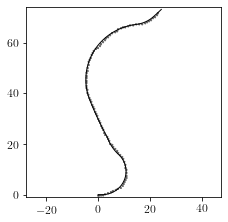

it: 032, loss: 1.135


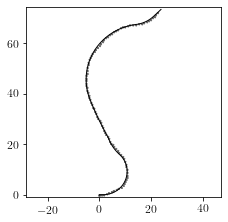

it: 033, loss: 1.129


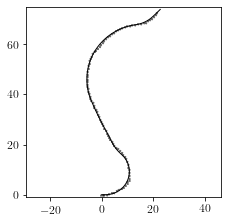

it: 034, loss: 1.129


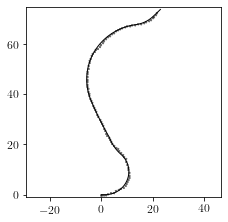

it: 035, loss: 1.124


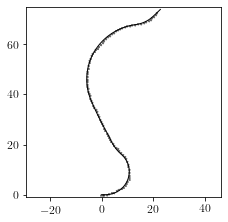

it: 036, loss: 1.119


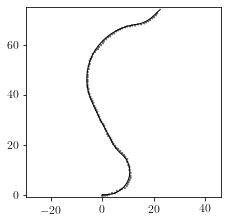

it: 037, loss: 1.118


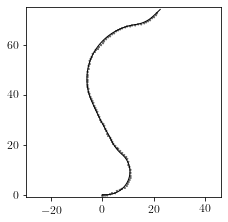

it: 038, loss: 1.117


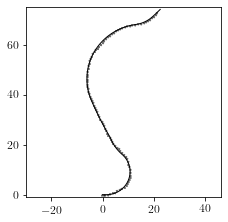

it: 039, loss: 1.115


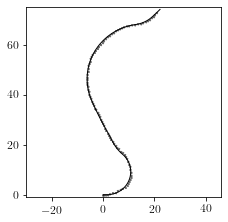

it: 040, loss: 1.112


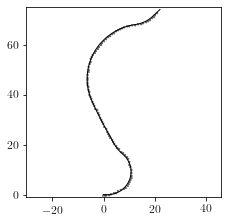

it: 041, loss: 1.111


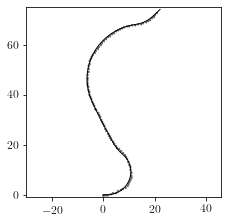

it: 042, loss: 1.110


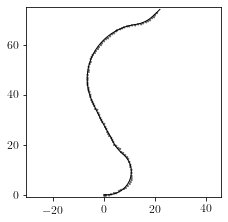

it: 043, loss: 1.107


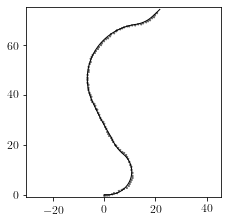

it: 044, loss: 1.106


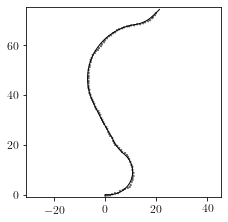

it: 045, loss: 1.103


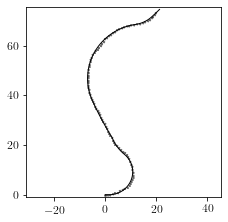

it: 046, loss: 1.103


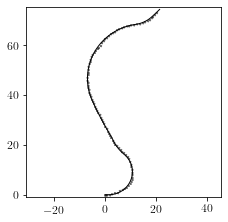

it: 047, loss: 1.101


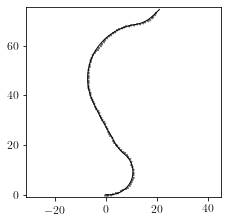

it: 048, loss: 1.101


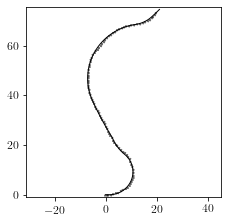

it: 049, loss: 1.100


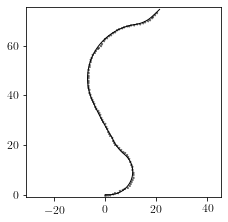

it: 050, loss: 1.099


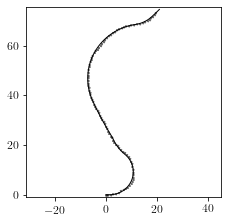

it: 051, loss: 1.096


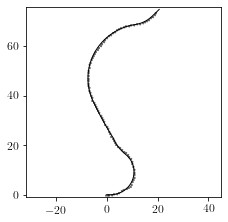

it: 052, loss: 1.094


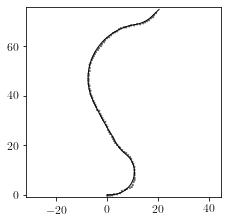

it: 053, loss: 1.093


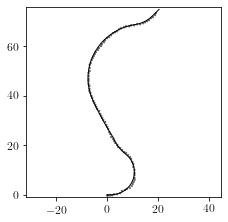

it: 054, loss: 1.092


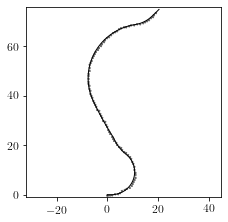

it: 055, loss: 1.089


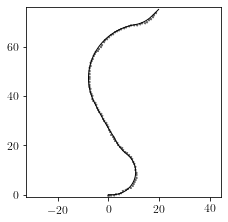

it: 056, loss: 1.088


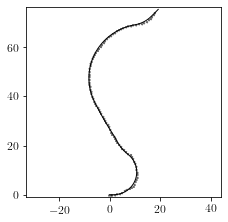

it: 057, loss: 1.088


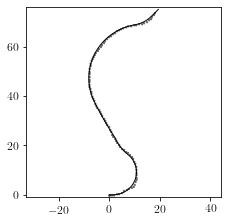

it: 058, loss: 1.087


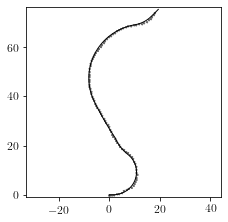

it: 059, loss: 1.087


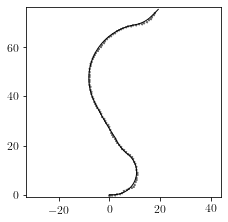

it: 060, loss: 1.087


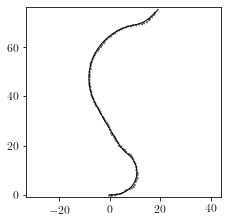

it: 061, loss: 1.087


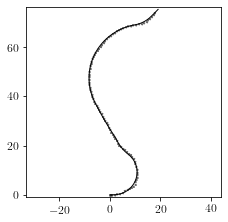

it: 062, loss: 1.085


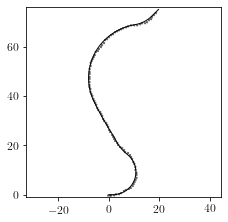

it: 063, loss: 1.085


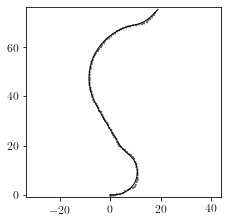

it: 064, loss: 1.084


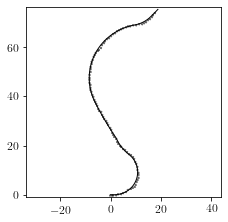

it: 065, loss: 1.084


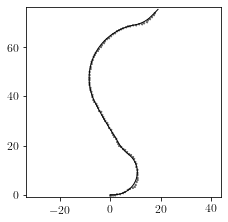

it: 066, loss: 1.085


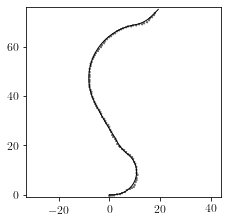

it: 067, loss: 1.085


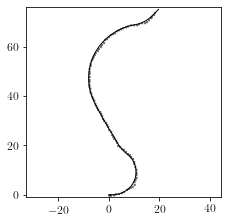

it: 068, loss: 1.084


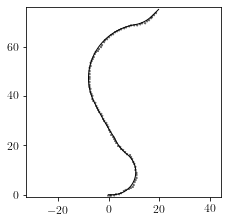

it: 069, loss: 1.082


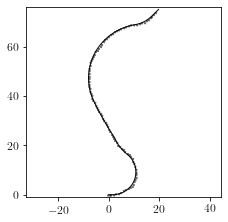

it: 070, loss: 1.082


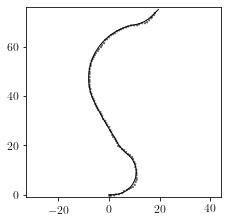

it: 071, loss: 1.081


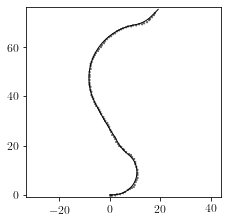

it: 072, loss: 1.072


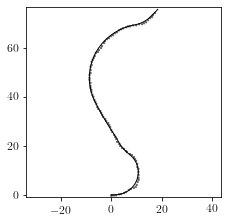

it: 073, loss: 1.072


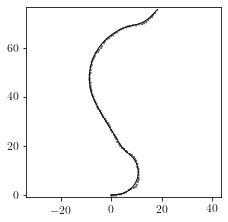

it: 074, loss: 1.070


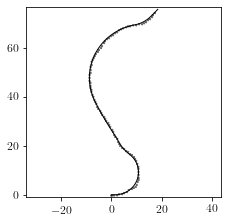

it: 075, loss: 1.071


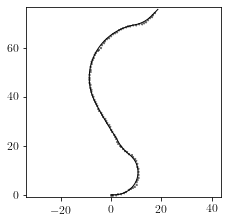

it: 076, loss: 1.071


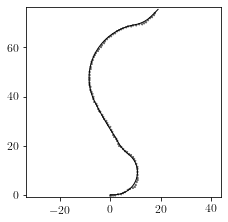

it: 077, loss: 1.071


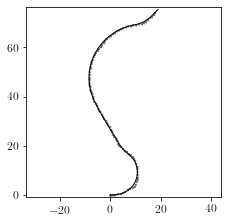

it: 078, loss: 1.065


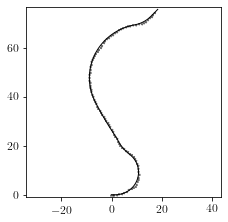

it: 079, loss: 1.064


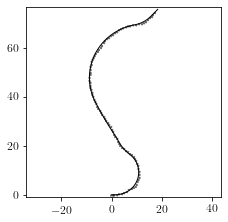

it: 080, loss: 1.063


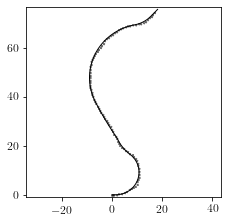

it: 081, loss: 1.064


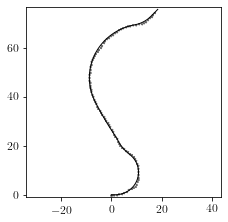

it: 082, loss: 1.063


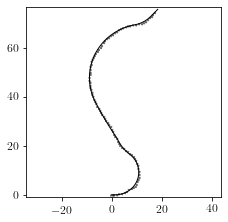

it: 083, loss: 1.063


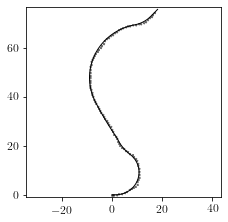

it: 084, loss: 1.062


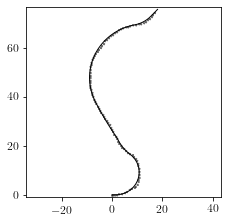

it: 085, loss: 1.060


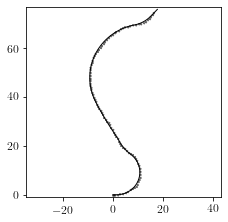

it: 086, loss: 1.060


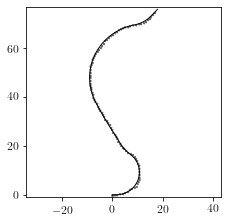

it: 087, loss: 1.060


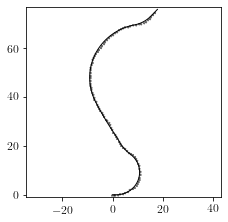

it: 088, loss: 1.060


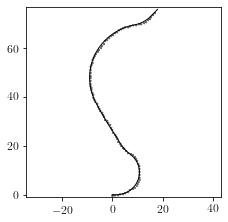

it: 089, loss: 1.060


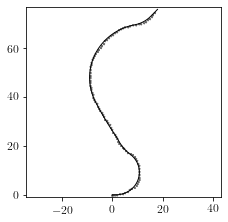

it: 090, loss: 1.060


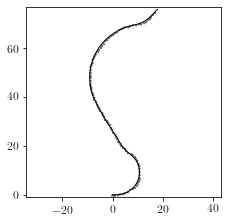

it: 091, loss: 1.060


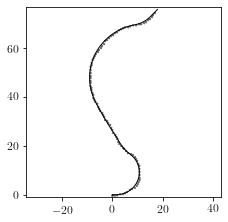

it: 092, loss: 1.060


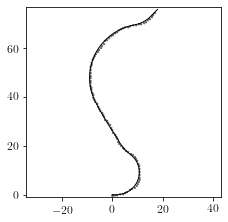

it: 093, loss: 1.060


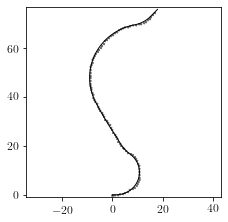

it: 094, loss: 1.059


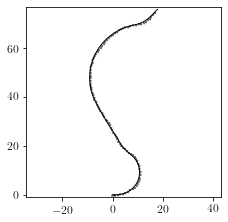

it: 095, loss: 1.059


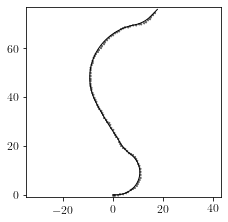

it: 096, loss: 1.059


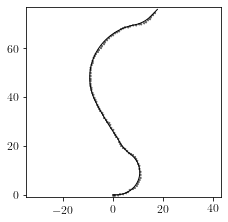

it: 097, loss: 1.058


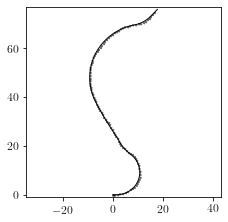

it: 098, loss: 1.058


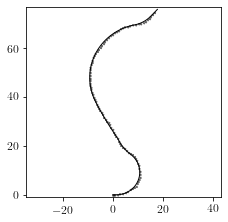

it: 099, loss: 1.058


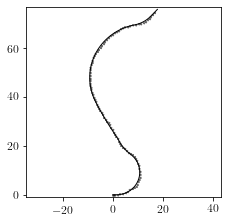

it: 100, loss: 1.057


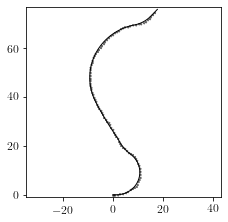

In [49]:
params = [P_sqrt, q]
opt = torch.optim.SGD(params, lr=.1)
losses = []
for k in range(100):
    with torch.no_grad():
        test_loss, X, U = loss(100, 4, P_sqrt.detach(), q.detach(), seed=0)
        losses.append(test_loss)
        print("it: %03d, loss: %3.3f" % (k+1, test_loss.item()))
    opt.zero_grad()
    l, _, _ = loss(100, 1, P_sqrt, q, seed=k+1)
    plt.show()
    l.backward()
    torch.nn.utils.clip_grad_norm_(params, 10)
    opt.step()
    latexify(fig_width=3.5, fig_height=3.5)
    plot_path(X[:,0,:])
    plt.savefig("figs/vehicle_%03d.pdf" % (k+1))
    plt.show()
    plt.close()

In [50]:
losses_monte_carlo_trained = [loss(100, 1, P_sqrt.detach(), q.detach(), seed=1000+k)[0] for k in range(100)]

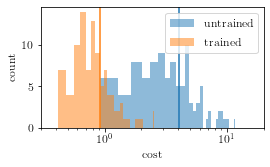

In [84]:
import matplotlib
latexify(fig_width=4)
plt.hist(losses_monte_carlo_untrained, bins=30, alpha=.5, label='untrained', color='tab:blue')
plt.hist(losses_monte_carlo_trained, bins=30, alpha=.5, label='trained', color='tab:orange')
plt.axvline(np.mean(losses_monte_carlo_untrained), color='tab:blue')
plt.axvline(np.mean(losses_monte_carlo_trained), color='tab:orange')
plt.xscale('log')
plt.legend()
plt.xlabel('cost')
plt.ylabel('count')
plt.xlim(.3, 20)
plt.subplots_adjust(bottom=.2)
plt.savefig('vehicle_hist.pdf')
plt.show()

In [57]:
np.mean(losses_monte_carlo_untrained)

4.055302906518939

In [58]:
np.mean(losses_monte_carlo_trained)

0.9117198912530743

In [20]:
P_sqrt.t() @ P_sqrt

tensor([[ 1.0007, -0.0456, -0.0100, -0.0290],
        [-0.0456,  1.0407,  0.1651, -0.0178],
        [-0.0100,  0.1651,  1.0839,  0.0905],
        [-0.0290, -0.0178,  0.0905,  0.9606]], grad_fn=<MmBackward>)

In [21]:
q

tensor([ 5.7754e-08, -2.1659e-02, -2.1434e-03, -1.3255e-02],
       requires_grad=True)

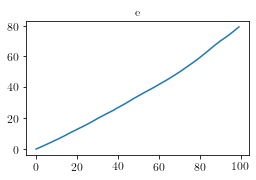

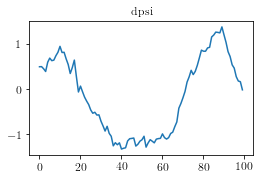

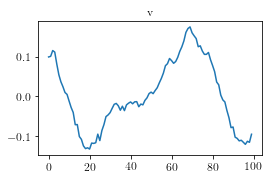

In [22]:
for i in range(3):
    plt.title((["e", "dpsi", "v"])[i])
    plt.plot(np.array(X)[:, 0, i])
    plt.show()

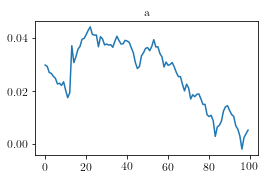

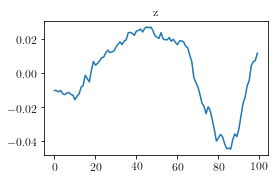

In [23]:
for i in range(2):
    plt.title((["a", "z"])[i])
    plt.plot(np.array(U)[:, 0, i])
    plt.show()